Things to change:
1. Increase sampling frequency
2. Change the range of plotted values for Doppler and SNR
3. Tinker with log plotting
4. Linspace and logspace

Notes:
1. Modulation
2. Complex Gaussian noise
3. Difference between channel gain and transmit gain
4. Constellation
5. Choices for sampling frequency based on Carrier, Nyquist

Additional things we could do?
1. Adaptive Modulation approach - BPSK, QAM
2. Error correcting codes
3. Filtering?

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
import math

In [412]:
# Signal and channel initialization
Fs = 10000   # Sampling frequency
Fc = 1e9    # Carrier frequency
Fd = 100    # Doppler frequency
Tc = 1 / (10*Fd)  # Coherence time (based on Doppler frequency)
N = 10000 # Number of data points in the signal
M = 3  # Number of different channel values (multi-path)
packet_size = math.floor(Fs*Tc)  # Size of each packet
noise_level = 1/10  # Noise level (1/SNR, dB value = 10*log10(SNR))
header_packet_size = math.floor((1/6) * packet_size)  # Known part of the signal

In [414]:
# Generate random digital signal
def generate_digital_signal(length):
    return np.random.choice([-1, 1], size=length)

In [416]:
# Jakes filter implementation
def Jakes_filter(f_max, Ts, N):
    L = N // 2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

# Generate Rayleigh envelope using Jakes model
def generate_rayleigh_envelope(signal_length, velocity, carrier_frequency):
    c = 3e8  # Speed of light in m/s
    fd = velocity * carrier_frequency / c
    Fs = 100000 # Sampling frequency
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N)
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h)
    return np.array(y[500:500 + signal_length])

In [418]:
# Initialize channel values using the Jakes model
channel_values = np.array([generate_rayleigh_envelope(N, 300, Fc) for _ in range(M)])


In [420]:
# Packet-wise processing
signal = generate_digital_signal(N)
cleaned_results = np.zeros((M, len(signal)))
scaled_results = np.zeros((M, len(signal)))
noisy_results = np.zeros((M, len(signal)))

header_error = np.zeros(M)
header_bit_count = np.zeros(M)
header_wrong_count = np.zeros(M)
num = np.zeros(M)

In [422]:
# Process each packet
for packet_start in range(0, len(signal), packet_size):
    packet_end = min(packet_start + packet_size, len(signal))
    current_signal = signal[packet_start:packet_end]
    current_channel_values = channel_values[:, packet_start:packet_end]

    for i in range(M):
        # Scale the signal by the channel values
        scaled = current_signal * current_channel_values[i]
        average_signal_power = np.mean(scaled ** 2)
        var_noise = average_signal_power * noise_level
        noise = np.random.normal(0, np.sqrt(var_noise), current_signal.shape)
        noisy = scaled + noise
        noisy_dig = digitize(noisy)

        # Perform Least Squares (LS) estimation
        header_start = int(packet_size / 2 - header_packet_size / 2)
        header_end = header_start + header_packet_size
        coeff, _, _, _ = lstsq(
            current_signal[header_start:header_end].reshape(-1, 1),
            noisy_dig[header_start:header_end]
        )

        # Use the coefficient to clean the signal
        cleaned_temp = noisy_dig / coeff
        cleaned = digitize(cleaned_temp)

        # Calculate header error
        header_error[i] += np.sum((coeff - current_channel_values[i, :header_end - header_start]) ** 2)
        header_wrong_count[i] += np.sum(current_signal[header_start:header_end] != cleaned[header_start:header_end])
        header_bit_count[i] += header_end - header_start

        # Store results
        cleaned_results[i, packet_start:packet_end] = cleaned
        scaled_results[i, packet_start:packet_end] = scaled
        noisy_results[i, packet_start:packet_end] = noisy


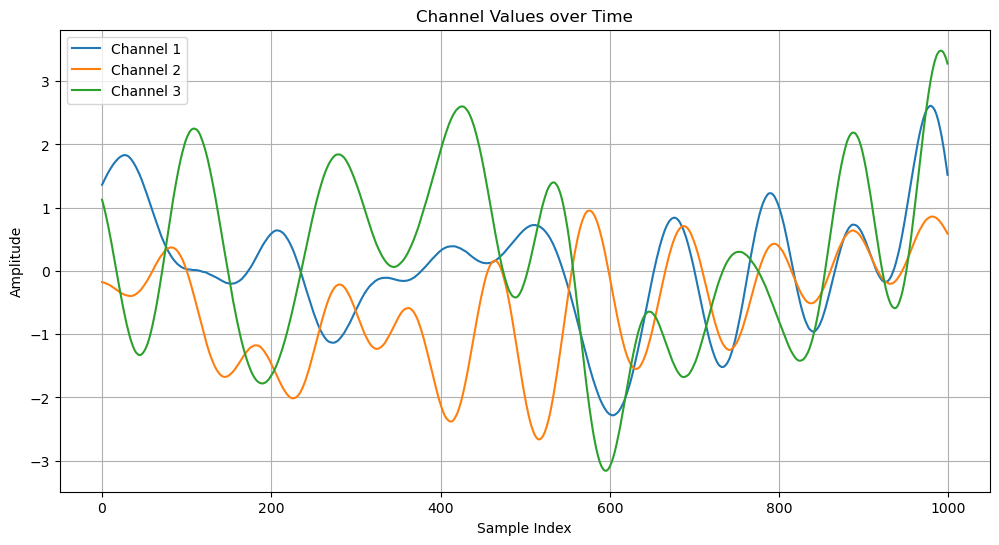

In [423]:
# Plotting the channel values
plt.figure(figsize=(12, 6))
for i in range(M):
    plt.plot(channel_values[i][:1000], label=f'Channel {i+1}')
plt.title('Channel Values over Time')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
    

In [425]:
# Compute MSE and BER for headers and data bits
header_mse = np.zeros(M)
data_ber = np.zeros(M)

for i in range(M):
    header_mse[i] = header_error[i] / header_bit_count[i]
    total_data_bits = 0
    corrupted_data_bits = 0

    for packet_start in range(0, len(signal), packet_size):
        data_start = packet_start + int(packet_size / 2 + header_packet_size / 2)
        data_end = min(packet_start + packet_size, len(signal))
        data_bits = signal[data_start:data_end]
        cleaned_data_bits = cleaned_results[i, data_start:data_end]

        total_data_bits += len(data_bits)
        corrupted_data_bits += np.sum(data_bits != cleaned_data_bits)

    data_ber[i] = corrupted_data_bits / total_data_bits

In [428]:
# Display the results
for i in range(M):
    print(f'Channel {i+1}: Header MSE = {header_mse[i]:.5f}, Data BER = {data_ber[i]:.9f}')

Channel 1: Header MSE = 0.47018, Data BER = 0.046200000
Channel 2: Header MSE = 0.53205, Data BER = 0.050000000
Channel 3: Header MSE = 0.48848, Data BER = 0.046800000
